# Penguin Classifier

Based on fastai course notebooks from lessons 1 and 2


## Training a penguin classifier model

After going through the fastai course (v3) I decided to try and create an image classifier for penguins, given that I have an interest in penguins, and I already have a penguin website www.patagoniapenguins.org - so I had a place to host my application.

There are 17 species of penguins. The first thing I noticed when I started, is that there are distinct groups of similar looking penguins - see Penguin Types. I thought it would be interesting to see if a machine leaning algorithm could distinguish between them.

My data set of penguins was built using google image search. See __penguins-download-data.ipynb__.

After initially training just using the defaults as per fastai course lessons 1 and 2, my error rate was around 0.2. This was quite a bit higher than the course examples, specifically the dogs/cats which were getting 0.06 using the same defaults/process.

These are some possible reasons for this:
* Certain species are very difficult to tell apart from a human perspective, e.g. Humboldt/Magellanic. As as expected, the model does struggle to distinguish between these species. I would like to work on improving this.
* Penguins like to hang around in colonies. It is rare to get a photo of an individual penguin. I don't know if this confuses the model, or whether it is just realistic, since images used for prediction will often contain multiple penguins. Most of the time the image will contain penguins of the same species.
* Penguins are generally the same shape and colour (i.e. black back, white front). Most distinguishing features are in the head, for example if the penguin has a crest. The fast.ai algorith, applies transformations to the images, including cropping them to a square. I am concerned that this might result in some of the distinguishing features to be lost if they are at the top of the image and are being cropped out.

I did some experiments on the image transforms - in particular trying to stop the penguin's head being cropped out. See 
0.115108
After trying the different parameters, including changing the default crop, the best outcome seems to be with resize_mode=SQUISH

In [5]:
from fastai.vision import *
from fastai.utils.mem import *
from fastai.utils import *
import torch
import gc

In [2]:
 gpu_mem_get()

GPUMemory(total=2048, free=1979, used=68)

## Set up data

In [7]:
path = Path('data/penguins')

In [8]:
classes = ['adelie', 'african', 'chinstrap', 'emperor', 'erect_crested', 'fiordland', 'galapagos', 'gentoo', 'humboldt', 
           'king', 'little', 'macaroni', 'magellanic', 'rockhopper', 'royal', 'snares', 'yellow_eyed']

## Set up methods

In [1]:
# clean memory
def clean_memory():
    collect_result = gc.collect()
    torch.cuda.empty_cache()
    mem_use = gpu_mem_get()
    print('collected ' + collect_result + ' ' + str(mem_use))
    print('')
   

In [2]:
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

In [3]:
@gpu_mem_restore
def do_cycles(data, cycles, save_name):
    learn = cnn_learner(data, models.resnet34, metrics=error_rate)
    learn.fit_one_cycle(cycles)
    learn.save(save_name)
    return learn

@gpu_mem_restore
def do_lr_find(learn):
    learn.unfreeze()
    learn.lr_find()

## Training

In [9]:
# create data bunch
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), 
        resize_method=ResizeMethod.SQUISH, size=244, bs=16, num_workers=4).normalize(imagenet_stats)

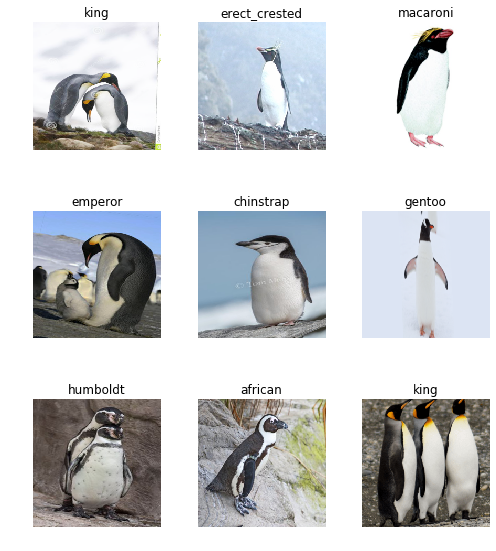

In [10]:
data.show_batch(rows=3, figsize=(7,8))

First train with 6 cycles

In [9]:
learn = do_cycles(data, 6, 'squish')

epoch,train_loss,valid_loss,error_rate,time
0,2.021546,1.194475,0.375899,00:57
1,1.161536,0.795191,0.253597,00:51
2,0.894796,0.730385,0.230216,00:52
3,0.729567,0.685175,0.210432,00:51
4,0.603111,0.650655,0.205036,00:52
5,0.533520,0.616777,0.188849,00:51


In [10]:
do_lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


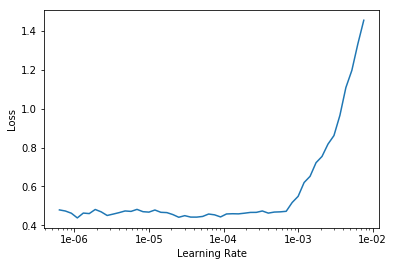

In [11]:
learn.recorder.plot()

In [12]:
# adjust learning rate
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.530544,0.596295,0.178058,01:04
1,0.470456,0.579213,0.160072,01:05
2,0.342504,0.559911,0.151079,01:04
3,0.289025,0.557135,0.160072,01:04


best error rate: 0.115108	

In [13]:
# save the learner
learn.save('squish-lr')

## Interpretation

Lets look at the results

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

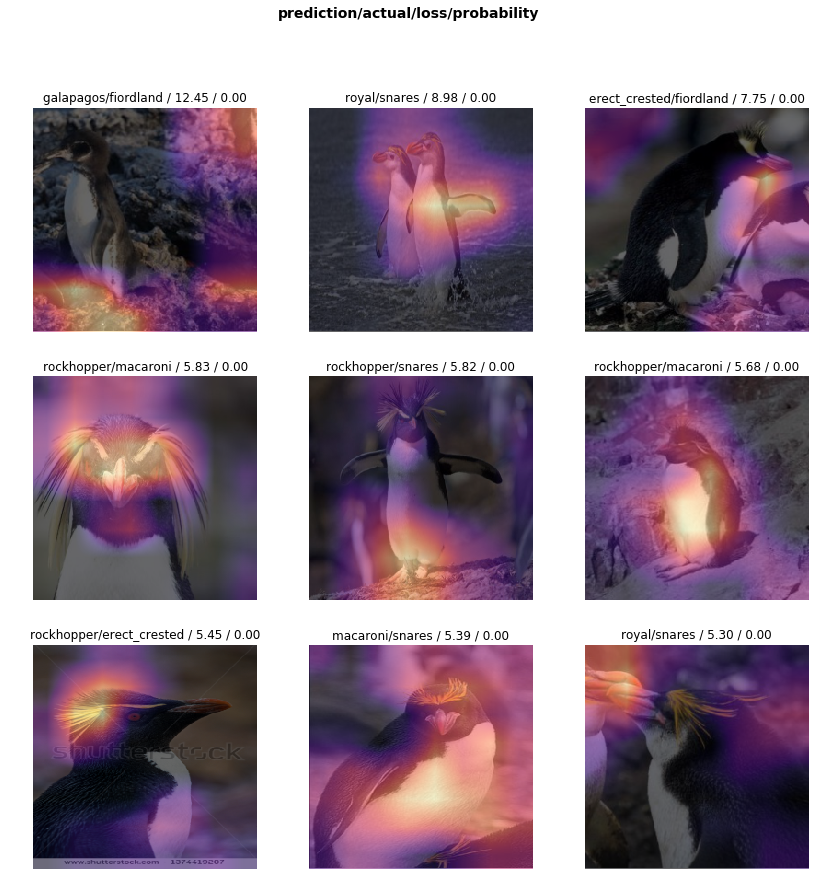

In [15]:
interp.plot_top_losses(9, figsize=(14,14))

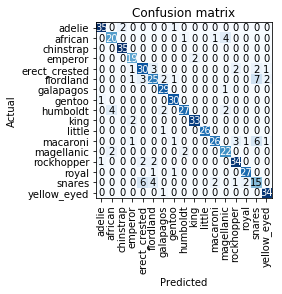

In [16]:
interp.plot_confusion_matrix()

In [17]:
interp.most_confused(min_val=2)

[('fiordland', 'snares', 7),
 ('macaroni', 'snares', 6),
 ('snares', 'erect_crested', 6),
 ('african', 'magellanic', 4),
 ('humboldt', 'african', 4),
 ('snares', 'fiordland', 4),
 ('erect_crested', 'fiordland', 3),
 ('fiordland', 'erect_crested', 3),
 ('macaroni', 'rockhopper', 3),
 ('adelie', 'chinstrap', 2),
 ('emperor', 'king', 2),
 ('erect_crested', 'rockhopper', 2),
 ('erect_crested', 'snares', 2),
 ('fiordland', 'galapagos', 2),
 ('fiordland', 'yellow_eyed', 2),
 ('humboldt', 'galapagos', 2),
 ('humboldt', 'magellanic', 2),
 ('king', 'emperor', 2),
 ('magellanic', 'african', 2),
 ('magellanic', 'humboldt', 2),
 ('rockhopper', 'erect_crested', 2),
 ('rockhopper', 'fiordland', 2),
 ('snares', 'macaroni', 2),
 ('snares', 'royal', 2)]

The confused species I would expect are as follows:
* crested penguins: fiordland/snares/macaroni/rockhopper/erect crested/royal
* warmer climate penguins humboldt/magellanic/african/galapagos
* emperor/king

couple of unexpected ones
* adelie/chinstrap
* fiordland/galapagos
* fiordland/yellow_eyed

In [19]:
# export model
learn.freeze()
learn.export(destroy=True) 

this Learner object self-destroyed - it still exists, but no longer usable
